## Import Libraries

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from PIL import Image, ImageOps, ImageEnhance
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

## Read images and transform the data

In [7]:

#* setting absolute path  for the project as base_dir
base_dir = os.path.abspath('.')
#* collecting data
original_img_dir = Path(base_dir,'TrashType_Image_Dataset')
transformer = T.Compose([T.Resize((32,32)), T.ToTensor()])
dataset = ImageFolder(original_img_dir, transform= transformer)

print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## distribution of files by class

d:\programs\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


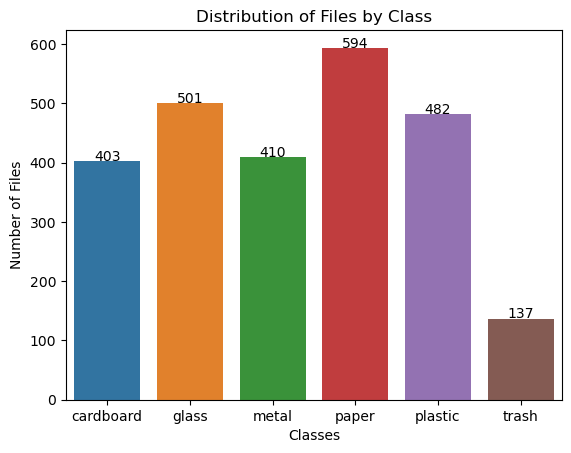

In [11]:
def count_files(directory):
    """
    This function takes a directory path as input and returns the number of files in that directory.
    """
    only_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(only_files)

classes_and_count = {}
# Example usage:
for claass in dataset.classes:
    directory = Path(original_img_dir, claass)
    classes_and_count[claass] = count_files(directory)
sns.barplot(x=list(classes_and_count.keys()), y=list(classes_and_count.values()))
plt.xlabel('Classes')
plt.ylabel('Number of Files')
plt.title('Distribution of Files by Class')
for i, v in enumerate(classes_and_count.values()):
    plt.text(i, v+0.5, str(v), ha='center')

plt.show()

## split and store the data into train and test data

In [14]:

#* generating gray and resized images
for claass in dataset.classes:
    image_path_org = Path(base_dir,'TrashType_Image_Dataset', claass)
    image_path_gray = Path(base_dir,'processed trashtype_image_dataset',claass)
    list_files = os.listdir(image_path_org)
    for file in list_files:
        read_img = Image.open(os.path.join(image_path_org, file))
        img = read_img.resize((32,32))
        gray = img.convert('L')
        gray.save(os.path.join(image_path_gray, file), "JPEG")